In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cbrain.imports import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.losses import *
from cbrain.data_generator import DataGenerator
import yaml

In [3]:
config_fn = '../../nn_config/000_example.yml'

In [89]:
class ModelDiagnostics():
    def __init__(self, config_fn, data_fn, nlat=64, nlon=128, nlev=30, ntime=48):
        
        self.nlat, self.nlon = nlat, nlon
        self.ngeo = nlat * nlon
        
        repo_dir = os.getcwd().split('CBRAIN-CAM')[0] + 'CBRAIN-CAM/'
        with open(config_fn, 'r') as f:
            config = yaml.load(f)
        
        self.model = tf.keras.models.load_model(repo_dir + 'saved_models/' + config['exp_name'] + '/model.h5',
                                                custom_objects={**layer_dict, **loss_dict})
        
        out_scale_dict = load_pickle(config['output_dict'])
        
        self.valid_gen = DataGenerator(
            data_fn=config['data_dir'] + config['valid_fn'],
            input_vars=config['inputs'],
            output_vars=config['outputs'],
            norm_fn=config['data_dir'] + config['norm_fn'],
            input_transform=(config['input_sub'], config['input_div']),
            output_transform=out_scale_dict,
            batch_size=self.ngeo,
            shuffle=False,
            xarray=True
        )
        
    def reshape_ngeo(self, x):
        return x.reshape(self.nlat, self.nlon, -1)
    
    def get_output_var_idx(self, var):
        var_idxs = self.valid_gen.norm_ds.var_names[self.valid_gen.output_idxs]
        var_idxs = np.where(var_idxs == var)[0]
        return var_idxs
        
    def get_truth_pred(self, itime, var=None):
        X, truth = self.valid_gen[itime]
        pred = self.model.predict_on_batch(X)
        # Inverse transform
        truth = self.valid_gen.output_transform.inverse_transform(truth.values)
        pred = self.valid_gen.output_transform.inverse_transform(pred)
        
        if var is not None:
            var_idxs = self.get_output_var_idx(var)
            truth = truth[:, var_idxs]
            pred = pred[:, var_idxs]
                                                        
        return self.reshape_ngeo(truth), self.reshape_ngeo(pred)
    
    # Plotting functions
    def plot_double_xy(self, itime, ilev, var, **kwargs):
        t, p = self.get_truth_pred(itime, var)
        if p.ndim == 3: p, t = p[:, :, ilev], t[:, :, ilev]
        return self.plot_double_slice(t, p, **kwargs)

    def plot_double_yz(self, itime, ilon, var, **kwargs):
        t, p = self.get_truth_pred(itime, var)
        return self.plot_double_slice(t[:, ilon, :].T, p[:, ilon, :].T, **kwargs)

    def plot_double_slice(self, t, p, title='', unit='', **kwargs):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        I1 = axes[0].imshow(p, **kwargs)
        I2 = axes[1].imshow(t, **kwargs)
        cb1 = fig.colorbar(I1, ax=axes[0], orientation='horizontal')
        cb2 = fig.colorbar(I2, ax=axes[1], orientation='horizontal')
        cb1.set_label(unit); cb2.set_label(unit)
        axes[0].set_title('CBRAIN Predictions')
        axes[1].set_title('SP-CAM Truth')
        fig.suptitle(title)
        return fig, axes

    def plot_slice(self, x, title='', unit='', **kwargs):
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        I = ax.imshow(x, **kwargs)
        cb = fig.colorbar(I, ax=ax, orientation='horizontal')
        cb.set_label(unit)
        ax.set_title(title)
        return fig
        
    # Statistics computation
    def compute_stats(self, niter=None):
        """Compute statistics in for [lat, lon, var, lev]"""
        nt = self.valid_gen.n_batches
        if niter is not None: nt = niter
        # Allocate stats arrays
        psum = np.zeros((self.nlat, self.nlon, self.valid_gen.n_outputs))
        tsum = np.copy(psum); sse = np.copy(psum)
        psqsum = np.copy(psum); tsqsum = np.copy(psum)
        for itime in tqdm(range(nt)):
            t, p = self.get_truth_pred(itime)   # [lat, lon, var, lev]
            # Compute statistics
            psum += p; tsum += t
            psqsum += p ** 2; tsqsum += t ** 2
            sse += (t - p) ** 2
        
        # Compute average statistics
        self.stats = {}
        pmean = psum / nt; tmean = tsum / nt
        self.stats['bias'] = pmean - tmean
        self.stats['mse'] = sse / nt
        self.stats['pred_mean'] = psum / nt
        self.stats['true_mean'] = tsum / nt
        self.stats['pred_sqmean'] = psqsum / nt
        self.stats['true_sqmean'] = tsqsum / nt
        self.stats['pred_var'] = psqsum / nt - pmean ** 2
        self.stats['true_var'] = tsqsum / nt - tmean ** 2
        self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
        # Compute horizontal stats [var, lev]
        self.stats['hor_tsqmean'] = np.mean(self.stats['true_sqmean'], axis=(0,1))
        self.stats['hor_tmean'] = np.mean(self.stats['true_mean'], axis=(0, 1))
        self.stats['hor_mse'] = np.mean(self.stats['mse'], axis=(0, 1))
        self.stats['hor_tvar'] = self.stats['hor_tsqmean'] - self.stats['hor_tmean'] ** 2
        self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])

    def mean_stats(self):
        """Get average statistics for each variable and returns dataframe"""
        df = pd.DataFrame(index=self.valid_gen.output_vars + ['all'], columns=list(self.stats.keys()))
        for ivar, var in enumerate(self.valid_gen.output_vars):
            for stat_name, stat in self.stats.items():
                # Stats have shape [lat, lon, var, lev]
                df.loc[var, stat_name] = np.mean(stat[..., self.get_output_var_idx(var)])
        df.loc['all']['hor_r2'] = np.mean(df['hor_r2'].mean())
        self.stats_df = df
        return df
    
    def save_stats(self, path=None):
        if path is None:
            os.makedirs('./tmp', exist_ok=True)
            path= './tmp/' + self.save_str
        with open(path, 'wb') as f: pickle.dump(self.stats, f)

    def load_stats(self, path=None):
        if path is None: path= './tmp/' + self.save_str
        with open(path, 'rb') as f: self.stats = pickle.load(f)
        

In [90]:
md = ModelDiagnostics(config_fn, '/local/S.Rasp/preprocessed_data/002_valid.nc')

In [91]:
md.compute_stats(10)

/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in true_divide
/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide


In [92]:
md.mean_stats()

,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,hor_tsqmean,hor_tmean,hor_mse,hor_tvar,hor_r2
PHQ,3.16427e-10,6.58571e-16,1.06228e-09,7.45855e-10,2.43276e-16,6.4669e-16,4.0107e-17,4.05465e-16,-inf,6.4669e-16,7.45855e-10,6.58571e-16,6.39766e-16,-inf
PHCLDLIQ,1.03695e-09,3.33295e-17,1.05401e-09,1.70567e-11,1.21565e-17,2.12819e-17,6.83318e-19,1.91785e-17,-inf,2.12819e-17,1.70567e-11,3.33295e-17,2.12776e-17,-inf
PHCLDICE,9.16751e-10,2.6237e-17,9.10529e-10,-6.22262e-12,1.98225e-17,6.46196e-18,2.26175e-18,5.88036e-18,-inf,6.46196e-18,-6.22262e-12,2.6237e-17,6.46067e-18,-inf
TPHYSTND,2.61263e-06,1.17788e-09,2.97937e-06,3.66744e-07,1.18142e-09,1.45126e-09,1.74863e-10,4.4006e-10,-4233.88,1.45126e-09,3.66744e-07,1.17788e-09,1.42643e-09,0.0248254
QRL,1.72649e-06,5.50588e-10,-1.54095e-05,-1.7136e-05,4.90195e-10,1.00924e-09,6.18253e-12,4.43428e-11,-23216.8,1.00924e-09,-1.7136e-05,5.50588e-10,5.65553e-10,-0.359507
QRS,-6.69692e-07,3.17701e-10,7.87913e-06,8.54882e-06,3.60105e-10,3.61466e-10,4.3809e-11,3.17489e-11,-inf,3.61466e-10,8.54882e-06,3.17701e-10,2.28339e-10,-0.904044
DTVKE,0.000345224,0.000330476,0.00102186,0.000676637,0.000316428,4.76617e-05,3.20644e-05,1.24174e-06,-3.38799e+15,4.76617e-05,0.000676637,0.000330476,3.57609e-05,-1.18329e+10
FSNT,-8.08084,5813.19,221.364,229.445,133942,158610,11010.6,15135.1,-inf,158610,229.445,5813.19,105965,0.94514
FSNS,-2.98299,1388.21,159.345,162.328,84130.8,87916.7,8158.63,9086.4,-inf,87916.7,162.328,1388.21,61566.5,0.977452
FLNT,-1.42701,538.401,222.182,223.609,50846.9,51866.7,37.6854,34.1458,-400.695,51866.7,223.609,538.401,1865.87,0.711448


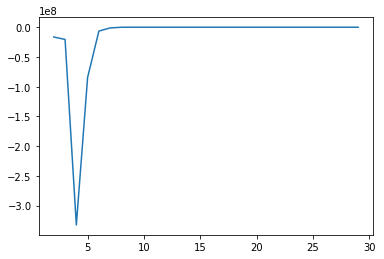

In [94]:
plt.plot(md.stats['hor_r2'][md.get_output_var_idx('PHQ')])